<a href="https://colab.research.google.com/github/AakankshaDahiya/Big-Data-Assignment/blob/main/dataanalysiscode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load datasets
primary = pd.read_csv("/content/finaldata.csv")
secondary = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")

# Rename columns (Primary)
primary.rename(columns={
    "How many steps do you walk daily?": "Steps",
    "How many hours do you sleep on average per day?": "SleepHours",
    "Rate your stress levels from 1-5": "Stress",
    "Rate your health from 1-5": "HealthRating",
    "Your Height (cm)": "Height_cm",
    "Your Weight (kg)": "Weight_kg",
    "How many calories do you consume per day?": "CaloriesIntake"
}, inplace=True)
primary["BMI"] = primary["Weight_kg"] / (primary["Height_cm"]/100)**2

# Rename columns (Secondary)
secondary = secondary[['Daily Steps', 'Sleep Duration', 'Stress Level', 'Quality of Sleep']]
secondary.rename(columns={
    'Daily Steps': 'Steps',
    'Sleep Duration': 'SleepHours',
    'Stress Level': 'Stress',
    'Quality of Sleep': 'HealthRating',
}, inplace=True)



In [ ]:
# Summary statistics
print("Primary Data Summary")
print(primary.describe())

print("Secondary Data Summary")
print(secondary.describe())


Primary Data Summary
              Steps  SleepHours  CaloriesIntake      Stress  HealthRating  \
count    116.000000  116.000000       21.000000  116.000000    116.000000   
mean    6881.137931    6.637931     1679.904762    2.646552      3.675000   
std     7281.897312    1.129806     1030.759036    1.105357      0.812899   
min       12.000000    4.000000        8.000000    1.000000      1.150000   
25%     3000.000000    6.000000     1200.000000    2.000000      3.000000   
50%     6000.000000    7.000000     1800.000000    3.000000      4.000000   
75%     8000.000000    8.000000     2500.000000    3.000000      4.000000   
max    51500.000000    9.000000     3000.000000    5.000000      5.000000   

        Height_cm   Weight_kg            BMI  ExerciseFreq_num  \
count   95.000000  110.000000      95.000000         60.000000   
mean   157.626316   69.878182    3542.332171          2.366667   
std     42.371841   13.687444   24952.276320          0.999435   
min      1.780000    

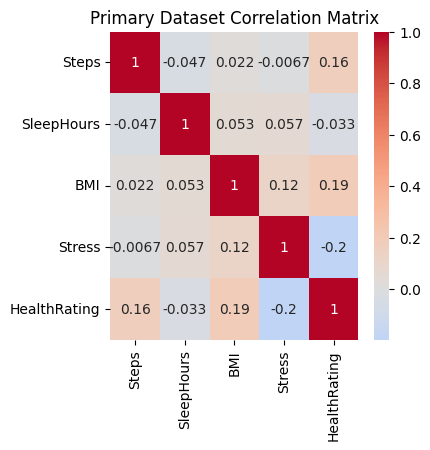

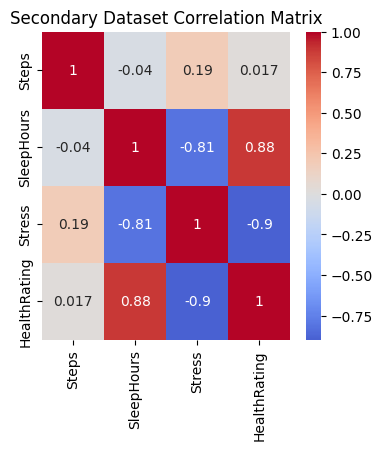

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Primary correlation
corr_primary = primary[['Steps','SleepHours','BMI','Stress','HealthRating']].corr()

plt.figure(figsize=(4,4))
sns.heatmap(corr_primary, annot=True, cmap="coolwarm", center=0)
plt.title("Primary Dataset Correlation Matrix")
plt.show()

# Secondary correlation
corr_secondary = secondary[['Steps','SleepHours','Stress','HealthRating']].corr()

plt.figure(figsize=(4,4))
sns.heatmap(corr_secondary, annot=True, cmap="coolwarm", center=0)
plt.title("Secondary Dataset Correlation Matrix")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# === PRIMARY: robust OLS prep + fit ===
need = ['Steps','SleepHours','BMI','Stress','HealthRating']
dfp = primary.copy()

# 1) Coerce to numeric
for c in need:
    if c in dfp.columns:
        dfp[c] = pd.to_numeric(dfp[c], errors='coerce')

# 2) Replace inf with NaN, then drop rows with any NaN in needed cols
dfp = dfp.replace([np.inf, -np.inf], np.nan)
dfp = dfp.dropna(subset=need)

# 3) Remove zero-variance predictors
X_cols = ['Steps','SleepHours','BMI','Stress']
const_like = [c for c in X_cols if dfp[c].nunique(dropna=True) <= 1]
if const_like:
    print("Removed constant predictors (primary):", const_like)
    X_cols = [c for c in X_cols if c not in const_like]

# 4) Sanity checks
if len(X_cols) < 2:
    raise ValueError("Too few valid predictors after cleaning (primary). Need at least 2 with >1 unique value.")
if len(dfp) < 20:
    print(f"Warning: small cleaned sample for primary: n={len(dfp)}")

# 5) Fit
X_p = sm.add_constant(dfp[X_cols], has_constant='add')
y_p = dfp['HealthRating']
model_p = sm.OLS(y_p, X_p).fit(cov_type='HC3')
print(model_p.summary())

                            OLS Regression Results                            
Dep. Variable:           HealthRating   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.270
Date:                Thu, 18 Sep 2025   Prob (F-statistic):              0.288
Time:                        15:51:05   Log-Likelihood:                -112.52
No. Observations:                  95   AIC:                             235.0
Df Residuals:                      90   BIC:                             247.8
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8978      0.550      7.084      0.0

In [ ]:
# Variables to use (no BMI column here)
need_s = ['Steps','SleepHours','Stress','HealthRating']
dfs = secondary.copy()

# Coerce to numeric
for c in need_s:
    dfs[c] = pd.to_numeric(dfs[c], errors='coerce')

# Clean inf/nan
dfs = dfs.replace([np.inf, -np.inf], np.nan).dropna(subset=need_s)

# Check predictors
X_cols_s = ['Steps','SleepHours','Stress']
print("Secondary predictors:", X_cols_s)

# Fit regression
import statsmodels.api as sm
X_s = sm.add_constant(dfs[X_cols_s], has_constant='add')
y_s = dfs['HealthRating']
model_s = sm.OLS(y_s, X_s).fit(cov_type='HC3')
print(model_s.summary())

Secondary predictors: ['Steps', 'SleepHours', 'Stress']
                            OLS Regression Results                            
Dep. Variable:           HealthRating   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2154.
Date:                Thu, 18 Sep 2025   Prob (F-statistic):          7.79e-234
Time:                        15:59:45   Log-Likelihood:                -172.86
No. Observations:                 374   AIC:                             353.7
Df Residuals:                     370   BIC:                             369.4
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd

# choose columns you intend to cluster on (or leave None to auto-pick numerics)
features = None  # e.g., ["age","income","score"]

df = primary.copy()

if features is None:
    features = df.select_dtypes(include=np.number).columns.tolist()

print("Using features:", features)
print("Shape:", df.shape)

# Count NaNs & infs
bad = df[features].replace([np.inf, -np.inf], np.nan)
print("\nNaNs per column:")
print(bad.isna().sum().sort_values(ascending=False).head(20))

# Rows that are ALL missing across chosen features
all_nan_rows = bad.isna().all(axis=1)
print(f"\nRows with ALL NaN in selected features: {all_nan_rows.sum()}")

# Columns that are ALL missing
all_nan_cols = bad.columns[bad.isna().all()]
print("Columns that are ALL NaN:", list(all_nan_cols))

# If every chosen column is bad, stop here and pick different features
assert len(features) > 0, "No features selected."
assert len(all_nan_cols) < len(features), "All chosen features are NaN. Pick different columns or fill them."

Using features: ['Steps', 'SleepHours', 'CaloriesIntake', 'Stress', 'HealthRating', 'Height_cm', 'Weight_kg', 'BMI', 'ExerciseFreq_num', 'ExerciseDuration_num', 'FastFoodFreq_num', 'SugaryDrinkFreq_num', 'WaterIntake_num']
Shape: (116, 29)

NaNs per column:
WaterIntake_num         116
ExerciseDuration_num     97
CaloriesIntake           95
ExerciseFreq_num         56
Height_cm                21
BMI                      21
FastFoodFreq_num          7
Weight_kg                 6
Steps                     0
HealthRating              0
Stress                    0
SleepHours                0
SugaryDrinkFreq_num       0
dtype: int64

Rows with ALL NaN in selected features: 0
Columns that are ALL NaN: ['WaterIntake_num']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector as Selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

# -------- helper (clusters one DataFrame) --------
def cluster_dataframe(df, n_clusters=3, random_state=42):
    d = df.copy()
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

    num_sel = Selector(dtype_include=np.number)
    cat_sel = Selector(dtype_exclude=np.number)

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
                ("scale", StandardScaler())
            ]), num_sel),
            ("cat", Pipeline([
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
            ]), cat_sel),
        ],
        remainder="drop"
    )

    # rows entirely NaN across selected features → drop for fitting
    num_cols, cat_cols = num_sel(d), cat_sel(d)
    if num_cols:
        mask_all_nan = d[num_cols].isna().all(axis=1)
    elif cat_cols:
        mask_all_nan = d[cat_cols].isna().all(axis=1)
    else:
        raise ValueError("No usable features found to cluster.")

    valid_idx = ~mask_all_nan
    if valid_idx.sum() == 0:
        raise ValueError("All rows are entirely missing across features.")

    pipe = Pipeline([
        ("prep", preprocess),
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto"))
    ])

    labels_valid = pipe.fit_predict(d.loc[valid_idx])
    d["Cluster"] = np.nan
    d.loc[valid_idx, "Cluster"] = labels_valid.astype(int)

    counts = pd.Series(labels_valid).value_counts().sort_index()
    return d["Cluster"], counts

# -------- run on BOTH datasets independently --------
# choose your k
K = 3

# PRIMARY
primary_clusters, primary_counts = cluster_dataframe(primary, n_clusters=K, random_state=42)
primary["Cluster"] = primary_clusters
print("PRIMARY cluster counts:")
print(primary_counts, "\n")

# SECONDARY
secondary_clusters, secondary_counts = cluster_dataframe(secondary, n_clusters=K, random_state=42)
secondary["Cluster"] = secondary_clusters
print("SECONDARY cluster counts:")
print(secondary_counts, "\n")

# -------- optional quick summaries for write-up --------
# (numeric features only, means by cluster)
if "Cluster" in primary.columns:
    print("PRIMARY means by cluster (numeric):")
    print(primary.groupby("Cluster").mean(numeric_only=True))
    print()

if "Cluster" in secondary.columns:
    print("SECONDARY means by cluster (numeric):")
    print(secondary.groupby("Cluster").mean(numeric_only=True))

PRIMARY cluster counts:
0    48
1     7
2    61
Name: count, dtype: int64 

SECONDARY cluster counts:
0    180
1    122
2     72
Name: count, dtype: int64 

PRIMARY means by cluster (numeric):
               Steps  SleepHours  CaloriesIntake    Stress  HealthRating  \
Cluster                                                                    
0.0      8677.083333    6.500000     2063.636364  2.208333      4.229167   
1.0      5357.142857    7.142857      804.000000  3.142857      4.285714   
2.0      5642.819672    6.688525     1371.250000  2.934426      3.168852   

          Height_cm  Weight_kg           BMI  ExerciseFreq_num  \
Cluster                                                          
0.0      172.868947  77.111111     25.389110          2.981481   
1.0       12.082857  61.371429  47766.512606          1.500000   
2.0      166.418000  65.293103     23.823636          1.913793   

         ExerciseDuration_num  FastFoodFreq_num  SugaryDrinkFreq_num  \
Cluster                

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['WaterIntake_num']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
